# 07 Add MSOA, LAD, and Postcode Centroids to ICB CSVs and GPKGs

This notebook:
- Enriches ICB-level data files by merging in MSOA and LAD
- Updates LSOA-level GeoPackages with MSOA and LAD

**Inputs:**
- ICB-level CSV(s) (e.g. `NHS_Bath_and_North_East_Somerset_Swindon_and_Wiltshire_Integrated_Care_Board_no_geom.csv`)
- Postcode lookup: `PCD_OA21_LSOA21_MSOA21_LAD_MAY24_UK_LU.csv`
- `lsoa_south_west.gpkg` and `lsoa_sw_enriched_demographics.gpkg`




In [69]:
import pandas as pd
import geopandas as gpd
import glob
import os
import matplotlib.pyplot as plt

# ---- File paths
lookup_path = "../data/raw/PCD_OA21_LSOA21_MSOA21_LAD_MAY24_UK_LU.csv"
icb_pattern = "../data/processed/icb_split/*.csv"
outdir = "../data/processed/icb_split_enriched/"
os.makedirs(outdir, exist_ok=True)

lsoa_gpkg = "../data/processed/lsoa_south_west.gpkg"
lsoa_demo_gpkg = "../data/processed/lsoa_sw_enriched_demographics.gpkg"
lsoa_gpkg_out = "../data/processed/lsoa_south_west_enriched.gpkg"
lsoa_demo_gpkg_out = "../data/processed/lsoa_sw_enriched_demographics_enriched.gpkg"


In [70]:
# ---- Load lookup and lower-case columns for consistency
lookup = pd.read_csv(lookup_path, dtype=str, encoding='latin1')
lookup.columns = lookup.columns.str.lower()
cols_needed = ['lsoa21cd', 'lsoa21nm', 'msoa21cd', 'msoa21nm', 'ladcd', 'ladnm']
lsoa_lookup = lookup[cols_needed].drop_duplicates('lsoa21cd')

In [71]:
for icb_file in glob.glob(icb_pattern):
    df = pd.read_csv(icb_file, dtype=str)
    cols = [c.lower() for c in df.columns]
    if 'lsoa21cd' in cols:
        lsoa_col = df.columns[cols.index('lsoa21cd')]
    else:
        raise ValueError(f"No LSOA21CD column found in {icb_file}")
    df = df.merge(lsoa_lookup, how='left', left_on=lsoa_col, right_on='lsoa21cd')
    # Report missing MSOA/LAD codes and names
    n_missing_msoa = df['msoa21cd'].isna().sum()
    n_missing_lad = df['ladcd'].isna().sum()
    n_missing_msoa_nm = df['msoa21nm'].isna().sum()
    n_missing_ladnm = df['ladnm'].isna().sum()
    print(
        f"\n[{os.path.basename(icb_file)}] Missing MSOA: {n_missing_msoa}, LAD: {n_missing_lad}, MSOA Name: {n_missing_msoa_nm}, LAD Name: {n_missing_ladnm}")
    # Optionally print first 5 rows with missing names
    if n_missing_ladnm > 0:
        print(df.loc[df['ladnm'].isna(), [lsoa_col, 'ladcd']].head())
    if n_missing_msoa_nm > 0:
        print(df.loc[df['msoa21nm'].isna(), [lsoa_col, 'msoa21cd']].head())
    # Save enriched output
    out_path = os.path.join(outdir, os.path.basename(icb_file).replace('.csv', '_enriched.csv'))
    df.to_csv(out_path, index=False)
    print(f"Enriched: {out_path}")


[NHS_Dorset_Integrated_Care_Board_no_geom.csv] Missing MSOA: 0, LAD: 0, MSOA Name: 0, LAD Name: 0
Enriched: ../data/processed/icb_split_enriched/NHS_Dorset_Integrated_Care_Board_no_geom_enriched.csv

[NHS_Gloucestershire_Integrated_Care_Board_no_geom.csv] Missing MSOA: 0, LAD: 0, MSOA Name: 0, LAD Name: 0
Enriched: ../data/processed/icb_split_enriched/NHS_Gloucestershire_Integrated_Care_Board_no_geom_enriched.csv

[NHS_Cornwall_and_the_Isles_of_Scilly_Integrated_Care_Board_no_geom.csv] Missing MSOA: 0, LAD: 0, MSOA Name: 0, LAD Name: 0
Enriched: ../data/processed/icb_split_enriched/NHS_Cornwall_and_the_Isles_of_Scilly_Integrated_Care_Board_no_geom_enriched.csv

[NHS_Somerset_Integrated_Care_Board_no_geom.csv] Missing MSOA: 0, LAD: 0, MSOA Name: 0, LAD Name: 340
    LSOA21CD      ladcd
0  E01029174  E06000066
1  E01029175  E06000066
2  E01029177  E06000066
3  E01029171  E06000066
4  E01035132  E06000066
Enriched: ../data/processed/icb_split_enriched/NHS_Somerset_Integrated_Care_Board_n

In [72]:
def enrich_gpkg(gpkg_in, gpkg_out, lsoa_lookup):
    gdf = gpd.read_file(gpkg_in)
    gdf.columns = [c.lower() for c in gdf.columns]
    if 'lsoa21cd' not in gdf.columns:
        raise ValueError(f"No LSOA21CD column found in {gpkg_in}")
    gdf = gdf.merge(lsoa_lookup, how='left', left_on='lsoa21cd', right_on='lsoa21cd')
    # Check for missing admin names
    for col in ['msoa21cd', 'ladcd', 'msoa21nm', 'ladnm']:
        missing = gdf[col].isna().sum()
        if missing > 0:
            print(f"{missing} records missing {col} in {gpkg_in}")
    # Patch missing ladnm if possible
    ladcd_to_ladnm = lookup.drop_duplicates('ladcd').set_index('ladcd')['ladnm'].to_dict()
    mask_missing = gdf['ladnm'].isna() & gdf['ladcd'].notna()
    gdf.loc[mask_missing, 'ladnm'] = gdf.loc[mask_missing, 'ladcd'].map(ladcd_to_ladnm)
    # Special case: Somerset Council (manual)
    gdf.loc[gdf['ladcd'] == 'E06000066', 'ladnm'] = "Somerset Council"
    # Save to disk
    gdf.to_file(gpkg_out, driver='GPKG')
    print(f"Saved enriched GeoPackage: {gpkg_out}")
    return gdf  # for visualisation/QA


gdf = enrich_gpkg(lsoa_gpkg, lsoa_gpkg_out, lsoa_lookup)
enrich_gpkg(lsoa_demo_gpkg, lsoa_demo_gpkg_out, lsoa_lookup)

339 records missing ladnm in ../data/processed/lsoa_south_west.gpkg
Saved enriched GeoPackage: ../data/processed/lsoa_south_west_enriched.gpkg
340 records missing ladnm in ../data/processed/lsoa_sw_enriched_demographics.gpkg
Saved enriched GeoPackage: ../data/processed/lsoa_sw_enriched_demographics_enriched.gpkg


,lsoa21cd,lsoa21nm_x,lsoa21nmw,bng_e,bng_n,lat,long,shape__are,shape__len,globalid,...,lad22cd,lad22nm,ruc21nm,urban_rural_flag,geometry,lsoa21nm_y,msoa21cd,msoa21nm,ladcd,ladnm
0,E01014014,Herefordshire 018C,None,363652,243381,52.08759,-2.53190,5.488187e+07,58635.757515,8fce111a-0aab-4f99-8777-1ed10d8b04b0,...,E06000019,"Herefordshire, County of",Smaller rural: Further from a major town or city,Other,GEOMETRYCOLLECTION (POLYGON ((368107.008 23624...,Herefordshire 018C,E02002922,Herefordshire 018,E06000019,"Herefordshire, County of"
1,E01014031,Herefordshire 023A,None,354699,217612,51.85525,-2.65915,1.949198e+07,28805.195706,77655486-1b21-4c99-a981-4f2fdb43ed95,...,E06000019,"Herefordshire, County of",Smaller rural: Further from a major town or city,Other,GEOMETRYCOLLECTION (POLYGON ((356772.719 21580...,Herefordshire 023A,E02002927,Herefordshire 023,E06000019,"Herefordshire, County of"
2,E01014032,Herefordshire 023B,None,359935,220422,51.88092,-2.58346,2.453930e+07,36178.876984,4a1dd37e-371d-4132-baa1-1e69fb6fd97d,...,E06000019,"Herefordshire, County of",Smaller rural: Further from a major town or city,Other,GEOMETRYCOLLECTION (POLYGON ((363208.682 21811...,Herefordshire 023B,E02002927,Herefordshire 023,E06000019,"Herefordshire, County of"
3,E01014036,Herefordshire 019B,None,371929,235664,52.01869,-2.41047,3.748703e+07,48290.644074,0a8efab5-acb9-44b2-acf0-e6a8d4bb460e,...,E06000019,"Herefordshire, County of",Smaller rural: Further from a major town or city,Other,GEOMETRYCOLLECTION (POLYGON ((375978.965 23592...,Herefordshire 019B,E02002923,Herefordshire 019,E06000019,"Herefordshire, County of"
4,E01014053,Herefordshire 023E,None,361436,228669,51.95517,-2.56258,4.982019e+07,49048.114559,61801e80-9228-4eed-962c-96a7143de5b7,...,E06000019,"Herefordshire, County of",Smaller rural: Further from a major town or city,Other,"MULTILINESTRING ((365681.829 229234.482, 36569...",Herefordshire 023E,E02002927,Herefordshire 023,E06000019,"Herefordshire, County of"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3470,E01035231,South Gloucestershire 035E,None,361945,177516,51.49530,-2.54956,4.409855e+05,3631.727536,ffe85ea9-855f-4746-b64d-7da442e1feab,...,E06000025,South Gloucestershire,Urban: Nearer to a major town or city,Urban,"POLYGON ((361912.501 177793.438, 361912.344 17...",South Gloucestershire 035E,E02007066,South Gloucestershire 035,E06000025,South Gloucestershire
3471,E01035232,South Gloucestershire 036B,None,362900,179544,51.51359,-2.53602,6.521226e+05,6000.022845,17eeb482-0456-4254-926a-bca01ea1c8e3,...,E06000025,South Gloucestershire,Urban: Nearer to a major town or city,Urban,"POLYGON ((363285 179955, 363286 179956, 363290...",South Gloucestershire 036B,E02007067,South Gloucestershire 036,E06000025,South Gloucestershire
3472,E01035233,South Gloucestershire 036C,None,364776,178494,51.50427,-2.50888,3.756758e+06,19835.100945,1d3957ec-72ae-4903-ab2c-63e4b0b674a1,...,E06000025,South Gloucestershire,Urban: Nearer to a major town or city,Urban,"POLYGON ((365764.117 179572.962, 365766.687 17...",South Gloucestershire 036C,E02007067,South Gloucestershire 036,E06000025,South Gloucestershire
3473,W01001595,Monmouthshire 007F,Sir Fynwy 007F,352036,208093,51.76945,-2.69649,1.821353e+07,26187.797067,f5cccd1a-7746-4f7f-a260-962673392079,...,W06000021,Monmouthshire,Smaller rural: Further from a major town or city,Other,GEOMETRYCOLLECTION (POLYGON ((353480.203 21014...,Monmouthshire 007F,W02000342,Monmouthshire 007,W06000021,Monmouthshire


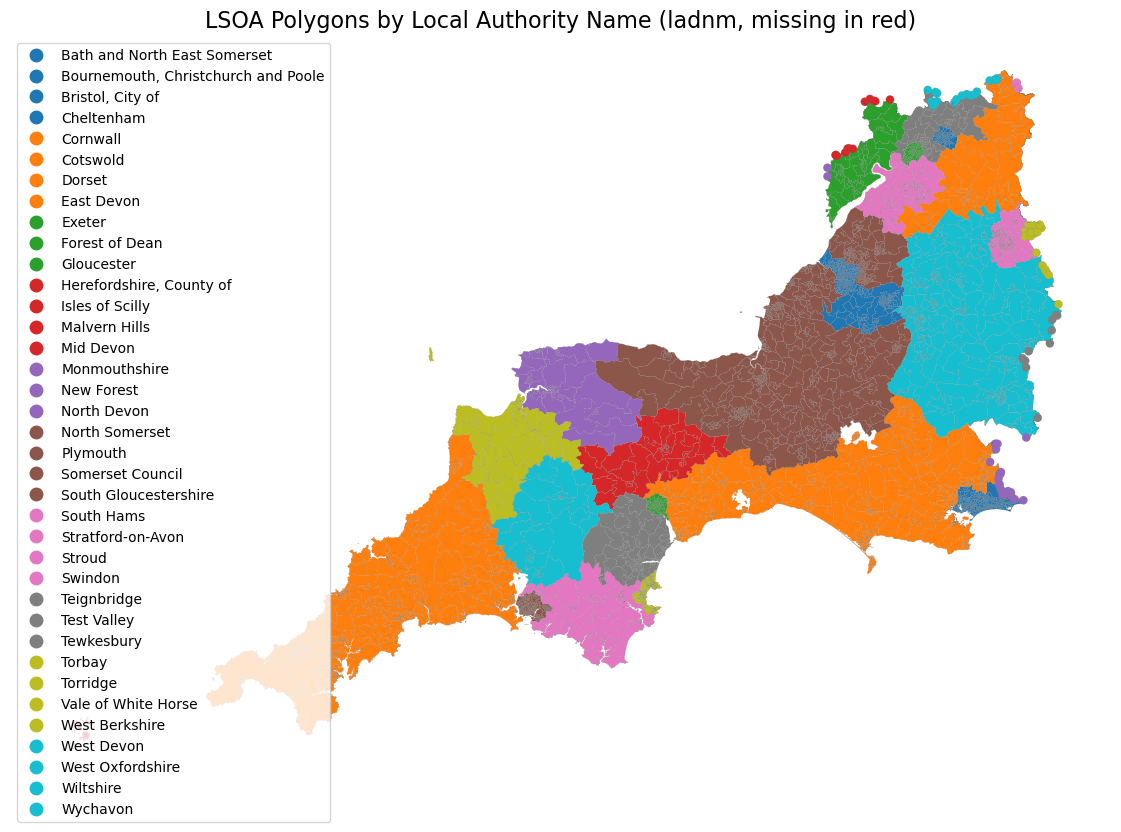

In [73]:

fig, ax = plt.subplots(figsize=(14, 9))
gdf['ladnm_plot'] = gdf['ladnm'].fillna('Missing LAD Name')
gdf.plot(ax=ax, column='ladnm_plot', categorical=True, legend=True, linewidth=0.1, edgecolor='grey')
plt.title('LSOA Polygons by Local Authority Name (ladnm, missing in red)', fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()

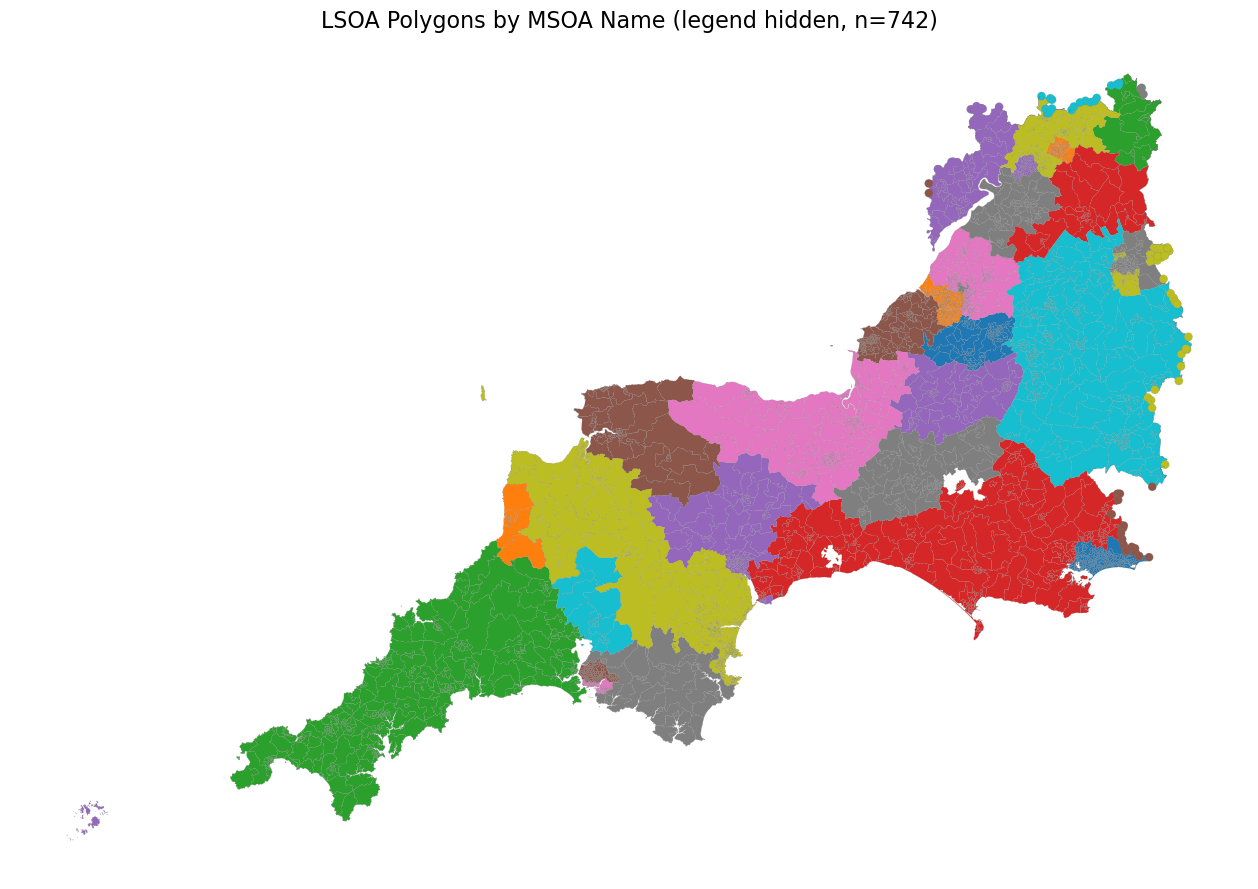

In [74]:
max_legend = 35
unique_msoas = gdf['msoa21nm'].nunique()
fig, ax = plt.subplots(figsize=(14, 9))
if unique_msoas <= max_legend:
    gdf.plot(ax=ax, column='msoa21nm', categorical=True, legend=True, linewidth=0.1, edgecolor='grey')
    plt.title('LSOA Polygons by MSOA Name (msoa21nm)', fontsize=16)
else:
    gdf.plot(ax=ax, column='msoa21nm', categorical=True, legend=False, linewidth=0.1, edgecolor='grey')
    plt.title(f'LSOA Polygons by MSOA Name (legend hidden, n={unique_msoas})', fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()

In [76]:
for col in ['msoa21nm', 'ladnm']:
    missing = gdf[gdf[col].isna()]
    print(f"Number of LSOAs with missing {col}: {missing.shape[0]}")
    if not missing.empty:
        fig, ax = plt.subplots(figsize=(10, 10))
        gdf.boundary.plot(ax=ax, color='lightgrey', linewidth=0.3)
        missing.plot(ax=ax, color='red', markersize=5)
        plt.title(f'LSOA Centroids with Missing {col.upper()}', fontsize=14)
        plt.axis('off')
        plt.show()
        print(missing[['lsoa21cd', col]].head())
    else:
        print(f"No missing {col} values.")

unmatched = set(gdf['lsoa21cd']) - set(lookup['lsoa21cd'])
print(f"Unmatched LSOA codes: {len(unmatched)}")

Number of LSOAs with missing msoa21nm: 0
No missing msoa21nm values.
Number of LSOAs with missing ladnm: 0
No missing ladnm values.
Unmatched LSOA codes: 0
